In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - OWL-ViT

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_owlvit.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_owlvit.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_owlvit.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a>
    (a Python-3 CPU notebook is recommended)
  </td>
</table>

## Overview

This notebook demonstrates deploying the pre-trained [OWL-ViT](https://huggingface.co/google/owlvit-base-patch32) model on Vertex AI for online prediction.

### Objective

- Upload the model to [Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction).
- Deploy the model on [Endpoint](https://cloud.google.com/vertex-ai/docs/predictions/using-private-endpoints).
- Run online predictions for image captioning.

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Setup environment

**NOTE**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Colab only

In [1]:
if "google.colab" in str(get_ipython()):
    ! pip3 install --upgrade google-cloud-aiplatform
    from google.colab import auth as google_auth

    google_auth.authenticate_user()

    # Restart the notebook kernel after installs.
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.5 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.1
    Uninstalling shapely-2.0.1:
      Successfully uninstalled shapely-2.0.1


### Setup Google Cloud project

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API and Compute Engine API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component).

1. [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs.

Fill following variables for experiments environment:

In [1]:
# Cloud project id.
PROJECT_ID = "boreal-complex-395517"  # @param {type:"string"}

# The region you want to launch jobs in.
REGION = "us-central1"  # @param {type:"string"}

# The Cloud Storage bucket for storing experiments output. Fill it without the 'gs://' prefix.
GCS_BUCKET = "testlupo"  # @param {type:"string"}

Initialize Vertex AI API:

In [2]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=GCS_BUCKET)

### Define constants

In [3]:
# The pre-built serving docker image. It contains serving scripts and models.
SERVE_DOCKER_URI = "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-transformers-serve"

### Define common functions

In [4]:
import base64
import os
from datetime import datetime
from io import BytesIO

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import requests
from google.cloud import aiplatform
from PIL import Image


def create_job_name(prefix):
    user = os.environ.get("USER")
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    job_name = f"{prefix}-{user}-{now}"
    return job_name


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def image_to_base64(image, format="JPEG"):
    buffer = BytesIO()
    image.save(buffer, format=format)
    image_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
    return image_str


def base64_to_image(image_str):
    image = Image.open(BytesIO(base64.b64decode(image_str)))
    return image


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


def draw_image_with_boxes(image, boxes):
    fig, ax = plt.subplots()
    plt.axis("off")
    ax.imshow(image)
    if len(boxes) == 0:
        return
    boxes = boxes["boxes"]
    for box in boxes:
        x, y = box["xmin"], box["ymin"]
        width, height = box["xmax"] - x, box["ymax"] - y
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=2, edgecolor="yellow", facecolor="none"
        )
        ax.add_patch(rect)
    plt.show()


def deploy_model(model_id, task):
    model_name = "owl-vit"
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-endpoint")
    serving_env = {
        "MODEL_ID": model_id,
        "TASK": task,
    }
    # If the model_id is a GCS path, use artifact_uri to pass it to serving docker.
    artifact_uri = model_id if model_id.startswith("gs://") else None
    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=SERVE_DOCKER_URI,
        serving_container_ports=[7080],
        serving_container_predict_route="/predictions/transformers_serving",
        serving_container_health_route="/ping",
        serving_container_environment_variables=serving_env,
        artifact_uri=artifact_uri,
    )
    model.deploy(
        endpoint=endpoint,
        machine_type="n1-standard-8",
        accelerator_type="NVIDIA_TESLA_T4",
        accelerator_count=1,
        deploy_request_timeout=1800,
    )
    return model, endpoint

## Upload and deploy models

This section uploads the pre-trained model to Model Registry and deploys it on the Endpoint with 1 T4 GPU.

The model deployment step will take ~15 minutes to complete.

Once deployed, you can send images and object texts to get bounding boxes.

In [ ]:
model, endpoint = deploy_model(
    model_id="google/owlvit-base-patch32", task="zero-shot-object-detection"
)

NOTE: The model weights will be downloaded after the deployment succeeds. Thus additional 5 minutes of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

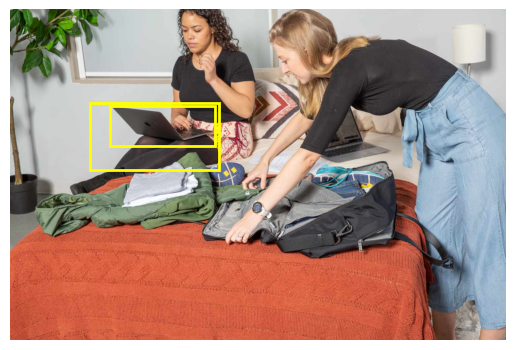

[{'boxes': [{'xmax': 618.0, 'score': 0.1637644469738007, 'xmin': 302.0, 'ymin': 292.0, 'ymax': 414.0}, {'xmin': 242.0, 'ymax': 484.0, 'ymin': 282.0, 'score': 0.1202412694692612, 'xmax': 633.0}], 'label': 'computer'}]


In [20]:
image = download_image("http://images.cocodataset.org/val2017/000000039769.jpg")
image = download_image("https://www.travelandleisure.com/thmb/hWzAinit76PioUFEIcK56uxwdv4=/fit-in/1500x3840/filters:no_upscale():max_bytes(150000):strip_icc()/weekend-bag-test-Away-The-Large-Everywhere-Bag-ConorRalph-02.jpg-19a681f89f1c4b118534c9887d591803.jpg")
instances = [
    {"image": image_to_base64(image), "text": "computer"},
]


preds = aiplatform.Endpoint("1037800438155444224").predict(instances=instances).predictions
draw_image_with_boxes(image, preds[0])
print(preds)

### Clean up resources

In [ ]:
# Undeploy model and delete endpoint.
endpoint.delete(force=True)

# Delete models.
model.delete()